In [690]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings 

from sklearn.utils.testing import all_estimators

# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit


from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor,BaggingRegressor
from sklearn.kernel_ridge import KernelRidge

import optuna

from sklearn.metrics import mean_squared_error,r2_score,make_scorer
from sklearn.preprocessing import RobustScaler,PowerTransformer


plt.rc('font', family='Malgun Gothic')
# plt.rc('font', family='AppleGothic')

mpl.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')


- 계획
    - 평가방법 : RMSE
    - 데이터 확인(describe,eda ) > 스케일링 > 검증!과 테스트 > 모델선정 > 평가 > 하이퍼파라미터수정

---   
#### 1. 데이터 불러오기 , 확인

In [3]:
data=pd.read_csv('./train.csv',encoding='utf-8')
test=pd.read_csv('./test.csv',encoding='utf-8')


In [4]:
data.head(2)

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0


In [5]:
test.head(2)

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0


In [7]:
sub.head(2)

,id,count
0,0,NaN
1,1,NaN


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [12]:
data.columns

Index(['id', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count'],
      dtype='object')

In [5]:
#id 삭제
del data['id']
del test['id']

In [16]:
data.describe()

#      시간	       기온   	강수유무(1,0)	       평균풍속	    습도   	가시성  	오존	       미세10	       미세2.5(초미세?)


,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1459.000000,1457.000000,1457.000000,1450.000000,1457.000000,1457.000000,1383.000000,1369.000000,1342.000000,1459.000000
mean,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,6.922790,5.239150,0.174917,1.378265,20.370387,583.131708,0.019509,31.771019,14.713252,82.631733
min,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,5.500000,12.800000,0.000000,1.400000,36.000000,879.000000,0.025500,36.000000,20.000000,37.000000
50%,11.000000,16.600000,0.000000,2.300000,51.000000,1577.000000,0.039000,51.000000,26.000000,96.000000
75%,17.500000,20.100000,0.000000,3.400000,69.000000,1994.000000,0.052000,69.000000,37.000000,150.000000
max,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


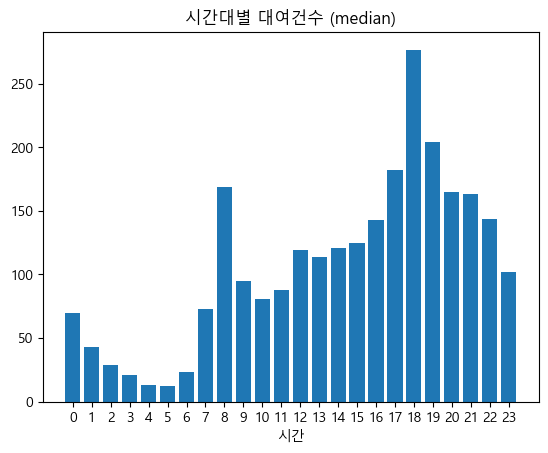

In [55]:
# 컬럼별 확인하기
# 시간 : data.groupby(by='hour').median()['count']
plt.title('시간대별 대여건수 (median)')
plt.bar(x=range(0,24),height=data.groupby(by='hour').median()['count'])
plt.xlabel('시간')
plt.xticks(range(0,24))
plt.show()

In [71]:
data.hour.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1459 entries, 0 to 1458
Series name: hour
Non-Null Count  Dtype
--------------  -----
1459 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [5]:
#test
test.hour.value_counts().sort_values()

18    29
16    29
21    29
17    29
5     29
4     30
13    30
6     30
22    30
9     30
8     30
20    30
7     30
14    30
12    30
11    30
10    30
15    30
0     30
1     30
19    30
23    30
3     30
2     30
Name: hour, dtype: int64

##### 시간대별 확인
- 출/퇴근 시간 (8시, 18시) 대여건수가 많음
- 오후시간대 대여건수가 많음
- 20시 전후를 기준으로 점차 대여 건수가 낮아짐 - 일출시간대와 동시에 대여량 증가
    > 가중치 시간 : 8시,20시   
    > 가중치 시간대 :오후 (12 ~ 20시)    
    설정해보자

---   
- 구간정하기
    - 18시
    - 8, 17,19시
    - 20,21,22,16,15,14,13,12
    - 0,7,9,10,11,23
    - 1,2,3,4,5,6


In [9]:
hour_bins={(18):5,(8,17,19):4,(12,13,14,15,16,20,21,22):3,(0,7,9,10,11,23):2,(1,2,3,4,5,6):1}

In [25]:
data['hour2']=data.hour.replace(hour_bins)
test['hour2']=test.hour.replace(hour_bins)


In [26]:
data.head(2)
test.head(2)

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,hour2
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0,2
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0,4


In [62]:
#기온 확인하기
data.groupby(by='hour_bef_temperature').median()['count']

#   소수점으로 기온값의 종류가 많은 > 구간만들기


hour_bef_temperature
3.1      14.0
3.2      21.0
3.3       7.0
4.0       8.0
4.2      16.0
        ...  
29.4    130.0
29.5    431.0
29.6    195.5
29.8    215.0
30.0    304.0
Name: count, Length: 245, dtype: float64

In [12]:
temp_bins = list(range(3, 33, 4))
len(temp_bins),temp_bins

(8, [3, 7, 11, 15, 19, 23, 27, 31])

In [13]:
temp_bins2 = list(range(3, 33, 2))
len(temp_bins2),temp_bins2

(15, [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31])

In [14]:
temp_bins_label=[str(x)+'이상'+str(x+4)+'미만' for x in temp_bins]
temp_bins_label

['3이상7미만',
 '7이상11미만',
 '11이상15미만',
 '15이상19미만',
 '19이상23미만',
 '23이상27미만',
 '27이상31미만',
 '31이상35미만']

In [15]:
temp_bins_label2=[str(x)+'이상'+str(x+2)+'미만' for x in temp_bins2]
temp_bins_label2

['3이상5미만',
 '5이상7미만',
 '7이상9미만',
 '9이상11미만',
 '11이상13미만',
 '13이상15미만',
 '15이상17미만',
 '17이상19미만',
 '19이상21미만',
 '21이상23미만',
 '23이상25미만',
 '25이상27미만',
 '27이상29미만',
 '29이상31미만',
 '31이상33미만']

In [16]:
data['bin_temperature'] = pd.cut(data["hour_bef_temperature"], temp_bins, right=False, labels=temp_bins_label[:-1])
data['bin_temperature2'] = pd.cut(data["hour_bef_temperature"], temp_bins2, right=False, labels=temp_bins_label2[:-1])
data.head(2)

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count,hour2,bin_temperature,bin_temperature2
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0,3,15이상19미만,15이상17미만
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0,3,19이상23미만,19이상21미만


In [17]:
data.groupby(by='bin_temperature').mean()['count']

bin_temperature
3이상7미만       39.125000
7이상11미만      53.148810
11이상15미만     64.559140
15이상19미만     97.908189
19이상23미만    157.224913
23이상27미만    195.375000
27이상31미만    227.102041
Name: count, dtype: float64

In [18]:
(data.groupby(by='bin_temperature2').mean()['count'])

bin_temperature2
3이상5미만       33.583333
5이상7미만       42.450000
7이상9미만       47.581395
9이상11미만      55.064000
11이상13미만     55.988764
13이상15미만     72.422680
15이상17미만     88.703125
17이상19미만    106.284360
19이상21미만    149.554348
21이상23미만    170.666667
23이상25미만    187.493333
25이상27미만    203.942029
27이상29미만    223.894737
29이상31미만    238.181818
Name: count, dtype: float64

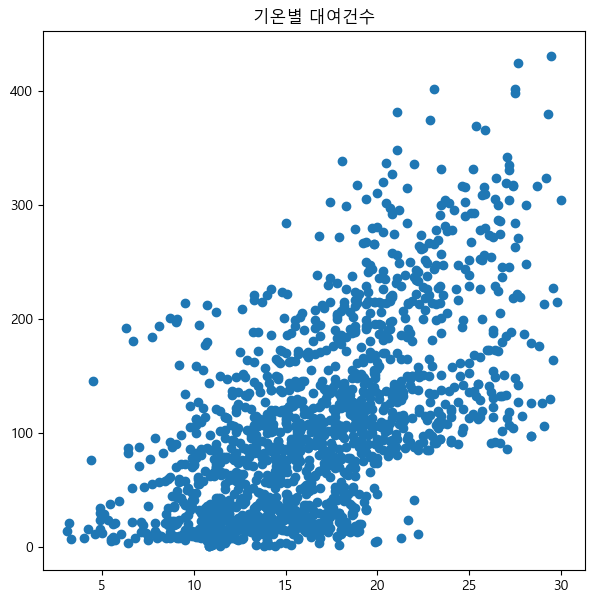

In [139]:
plt.figure(figsize=(7,7))
plt.title('기온별 대여건수')
plt.scatter(data['hour_bef_temperature'],data['count'])
# plt.xlabel(temp_bins_label)
plt.show()

In [148]:
data.groupby(by='hour_bef_temperature').mean()['count']


hour_bef_temperature
3.1      14.0
3.2      21.0
3.3       7.0
4.0       8.0
4.2      16.0
        ...  
29.4    130.0
29.5    431.0
29.6    195.5
29.8    215.0
30.0    304.0
Name: count, Length: 245, dtype: float64

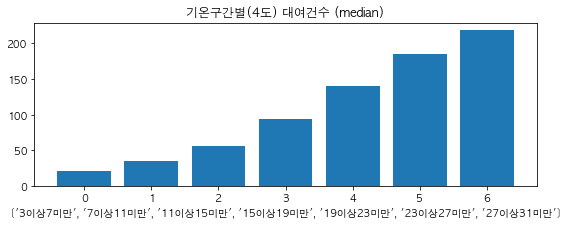

In [24]:
plt.figure(figsize=(9,3))
plt.title('기온구간별(4도) 대여건수 (median)')
plt.bar(x=range(0,7),height=data.groupby(by='bin_temperature').median()['count'])
plt.xlabel(temp_bins_label[:-1])
plt.show()

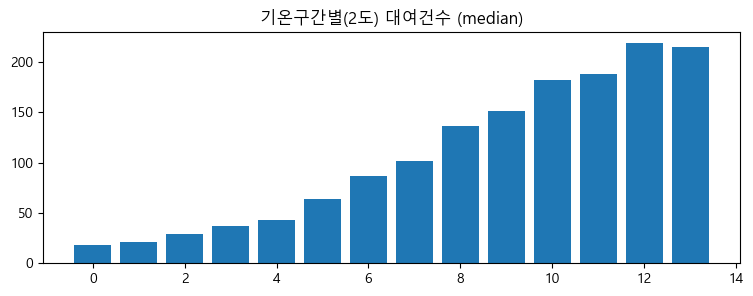

In [171]:
plt.figure(figsize=(9,3))
plt.title('기온구간별(2도) 대여건수 (median)')
plt.bar(x=range(0,14),height=data.groupby(by='bin_temperature2').median()['count'])
plt.show()

In [191]:
#test
test.hour_bef_temperature.describe(), test.hour_bef_temperature.value_counts()

(count    714.000000
 mean      23.263305
 std        4.039645
 min       14.600000
 25%       20.300000
 50%       22.900000
 75%       26.375000
 max       33.800000
 Name: hour_bef_temperature, dtype: float64,
 20.9    14
 22.8    12
 24.3    12
 23.3    12
 23.7    12
         ..
 15.1     1
 16.4     1
 30.2     1
 30.5     1
 15.9     1
 Name: hour_bef_temperature, Length: 171, dtype: int64)

In [33]:
test.hour_bef_temperature.value_counts().sort_index
test.hour_bef_temperature.max()

33.8

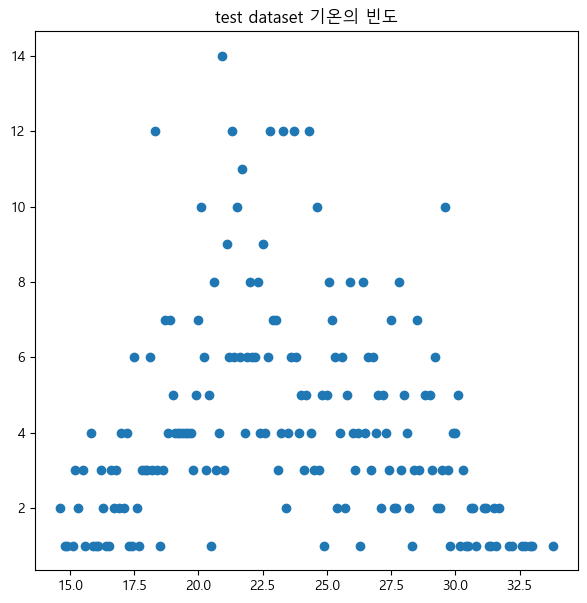

In [192]:
plt.figure(figsize=(7,7))
plt.title('test dataset 기온의 빈도')
plt.scatter((test.hour_bef_temperature.value_counts()).index,(test.hour_bef_temperature.value_counts()).values)
plt.show()

# test dataset의 기온 최고값이 더 큼 (33.8)

##### 기온별 확인
- 기온이 상승할수록 (~30) 대여건수는 지속적으로 증가함 (mean) / median-기온이 가장 높은 구간 (29이상31미만) 다소 감소
    > 기온값 그대로(+스케일링) 가중치 부여 + 고온일때 패널티 사용?
---

▼

In [34]:
# 30도 이상일 경우> 초과되는 만큼 30에서 빼기
data['temp']=data.hour_bef_temperature.apply(lambda k : 30-(k-30) if k>30 else k)
test['temp']=test.hour_bef_temperature.apply(lambda k : 30-(k-30) if k>30 else k)

In [35]:
data.head(2)

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count,hour2,bin_temperature,bin_temperature2,temp
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0,3,15이상19미만,15이상17미만,16.3
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0,3,19이상23미만,19이상21미만,20.1


---

In [155]:
# 강수
data['hour_bef_precipitation'].value_counts()

0.0    1411
1.0      46
Name: hour_bef_precipitation, dtype: int64

In [166]:
data.groupby(by='hour_bef_precipitation').median()['count'] ,
data.groupby(by='hour_bef_precipitation').mean()['count']

(hour_bef_precipitation
 0.0    99.0
 1.0    19.5
 Name: count, dtype: float64,
 hour_bef_precipitation
 0.0    111.130404
 1.0     33.673913
 Name: count, dtype: float64)

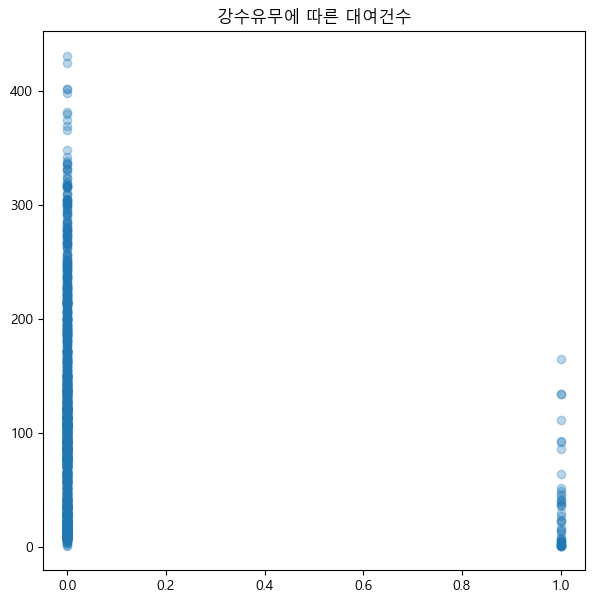

In [260]:
plt.figure(figsize=(7,7))
plt.title('강수유무에 따른 대여건수')
plt.scatter(data['hour_bef_precipitation'],data['count'],alpha=0.3)
plt.show()

In [201]:
# 비가 오지 않은 날 
data[data['hour_bef_precipitation']==0.0]['count'].max()    #   대여건수의 최대값 : 431.0
data[data['hour_bef_precipitation']==0.0]['count'].mean()   #   대여건수의 평균값: 111.13040396881644
data[data['hour_bef_precipitation']==0.0]['count'].median() #   대여건수의 중앙값 : 99.0


# 비가 온 날
data[data['hour_bef_precipitation']==1.0]['count'].max()        #   대여건수의 최대값 : 165.0
data[data['hour_bef_precipitation']==1.0]['count'].mean()       #   대여건수의 평균값: 33.67391304347826
data[data['hour_bef_precipitation']==1.0]['count'].median()     #   대여건수의 중앙값 : 19.5


19.5

In [217]:
no_rain=data[data['hour_bef_precipitation']==0.0]['count']
yes_rain=data[data['hour_bef_precipitation']==1.0]['count']


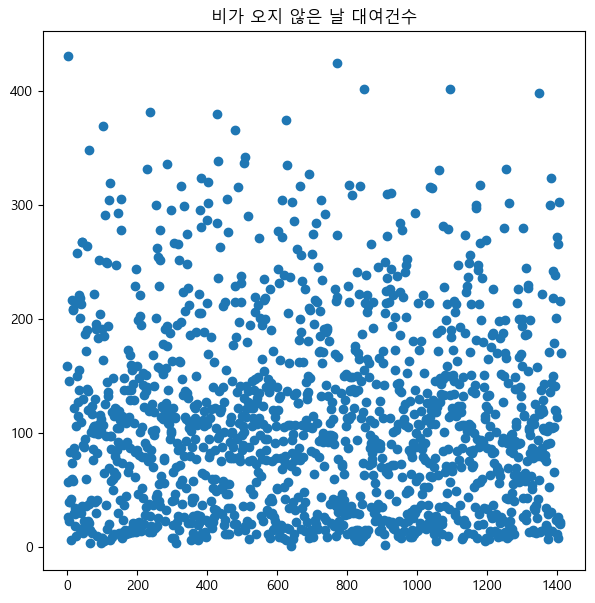

In [218]:
plt.figure(figsize=(7,7))
plt.title('비가 오지 않은 날 대여건수')
plt.scatter(range(len(no_rain)), data[data['hour_bef_precipitation']==0.0]['count'])
plt.show()


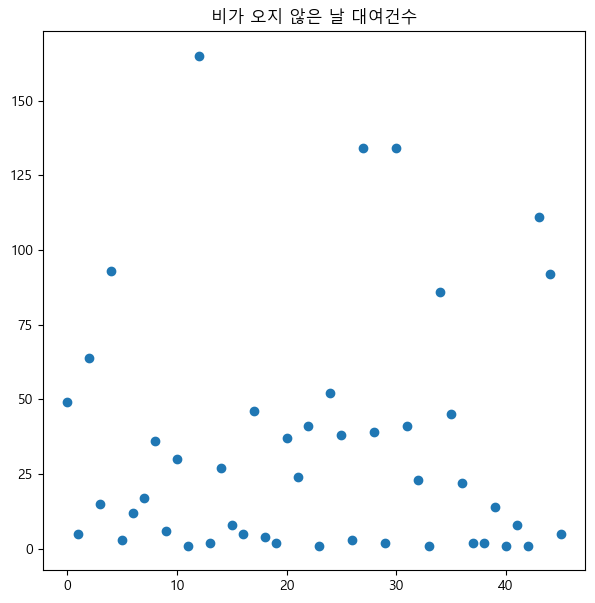

In [219]:
plt.figure(figsize=(7,7))
plt.title('비가 오지 않은 날 대여건수')
plt.scatter(range(len(yes_rain)), data[data['hour_bef_precipitation']==1.0]['count'])
plt.show()

In [54]:
# test
test['hour_bef_precipitation'].value_counts()

0.0    677
1.0     37
Name: hour_bef_precipitation, dtype: int64

##### 강수유무별 확인
- 비가 오는 날에도 자전거를 타는 사람이 있구나 
- 자전거를 빌린 상태에서 비가 온걸까?
- 비오는날 왜 자전거를 탈까

    > 그대로 사용 가능할듯
---

In [ ]:
data.to_csv('./data1.csv',encoding='utf-8',index=False)
test.to_csv('./test1.csv',encoding='utf-8',index=False)

In [78]:
data=pd.read_csv('./data1.csv',encoding='utf-8')
test=pd.read_csv('./test1.csv',encoding='utf-8')

In [224]:
# 평균풍속 hour_bef_windspeed

data.hour_bef_windspeed.value_counts()

2.0    46
1.8    45
1.4    43
2.7    41
2.1    40
       ..
7.7     1
6.7     1
7.3     1
7.4     1
7.0     1
Name: hour_bef_windspeed, Length: 73, dtype: int64

In [226]:
data.groupby(by='hour_bef_windspeed').median()['count']

hour_bef_windspeed
0.0      9.0
0.1     27.0
0.2     27.5
0.3     31.0
0.4     24.0
       ...  
7.3     66.0
7.4    115.0
7.5      3.0
7.7     21.0
8.0     46.0
Name: count, Length: 73, dtype: float64

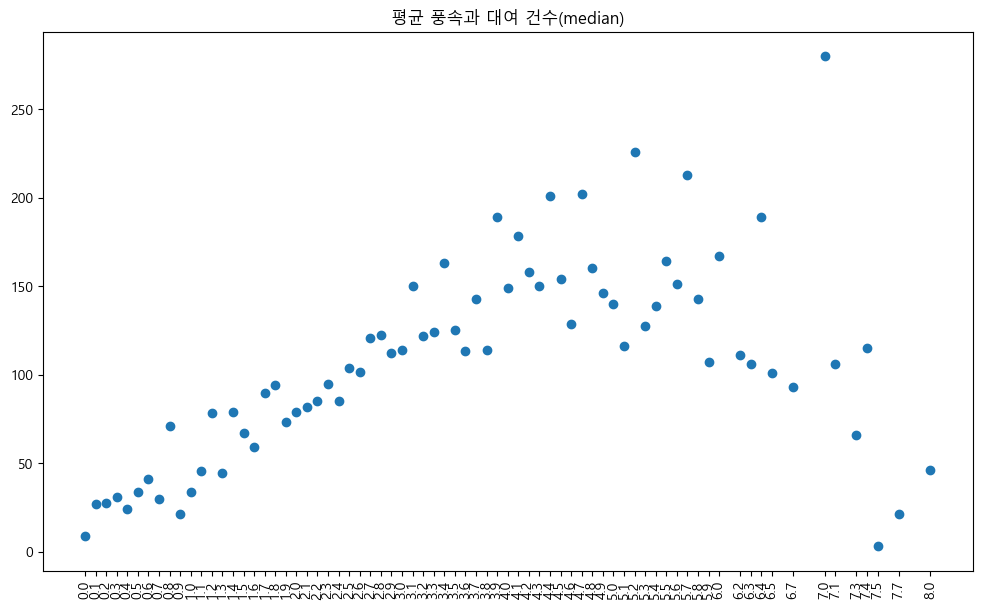

In [245]:
idx=data.groupby(by='hour_bef_windspeed').median()['count'].index
value=data.groupby(by='hour_bef_windspeed').median()['count'].values

plt.figure(figsize=(12,7))
plt.title('평균 풍속과 대여 건수(median)')
plt.scatter(idx,value)
plt.xticks(idx,rotation=90)
plt.show()

In [248]:
data.hour_bef_windspeed.describe()

count    1450.000000
mean        2.479034
std         1.378265
min         0.000000
25%         1.400000
50%         2.300000
75%         3.400000
max         8.000000
Name: hour_bef_windspeed, dtype: float64

In [247]:
test.hour_bef_windspeed.describe()

count    714.000000
mean       2.388515
std        1.171270
min        0.000000
25%        1.500000
50%        2.300000
75%        3.275000
max        5.900000
Name: hour_bef_windspeed, dtype: float64

##### 평균 풍속별 확인
- 0~5 대여 건수는 계속 증가, 이후 감소
- test dataset의 범위는 train보다 작음 

    > 구간에 따라 다른 가중치 필요할듯 : 5이하+ / 5초과 -
    
---

In [79]:
# 5초과시 : 5 - 초과정도

data['wind']=data.hour_bef_windspeed.apply(lambda k : 5-(k-5) if k>5 else k)
test['wind']=test.hour_bef_windspeed.apply(lambda k : 5-(k-5) if k>5 else k)

data.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count,hour2,bin_temperature,bin_temperature2,temp,wind
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0,3,15이상19미만,15이상17미만,16.3,1.5
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0,3,19이상23미만,19이상21미만,20.1,1.4
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0,1,11이상15미만,13이상15미만,13.9,0.7
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0,2,7이상11미만,7이상9미만,8.1,2.7
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0,5,27이상31미만,29이상31미만,29.5,4.8


In [250]:
# 습도
data.hour_bef_humidity.value_counts()

44.0    34
39.0    30
76.0    30
55.0    30
71.0    30
        ..
8.0      1
10.0     1
95.0     1
7.0      1
9.0      1
Name: hour_bef_humidity, Length: 91, dtype: int64

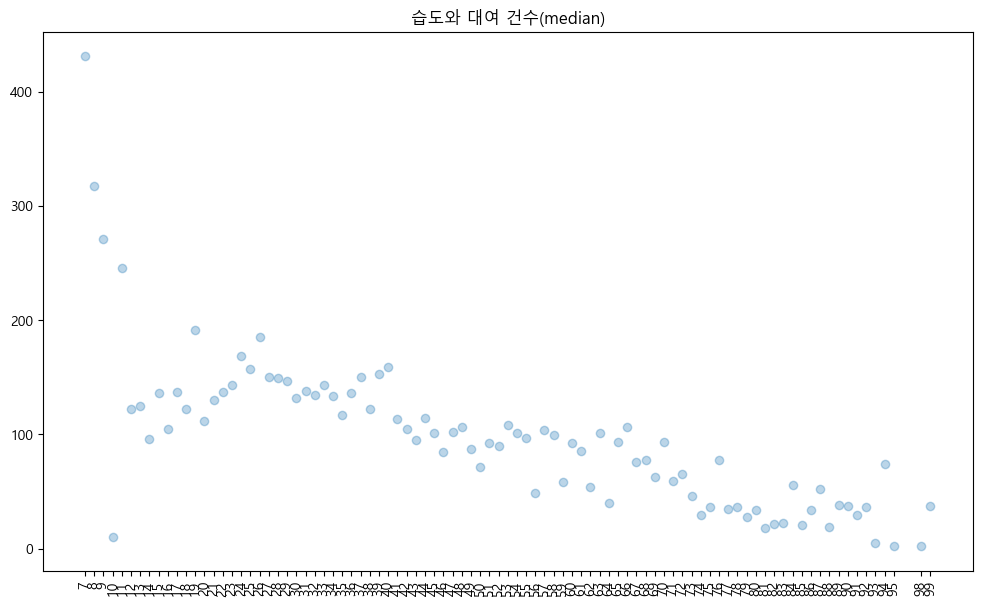

In [259]:
idx=data.groupby(by='hour_bef_humidity').median()['count'].index
value=data.groupby(by='hour_bef_humidity').median()['count'].values

plt.figure(figsize=(12,7))
plt.title('습도와 대여 건수(median)')
plt.scatter(idx,value,alpha=0.3)
plt.xticks(idx,rotation=90)
plt.show()

In [258]:
data.hour_bef_humidity.describe()

count    1457.000000
mean       52.231297
std        20.370387
min         7.000000
25%        36.000000
50%        51.000000
75%        69.000000
max        99.000000
Name: hour_bef_humidity, dtype: float64

In [257]:
test.hour_bef_humidity.value_counts()
test.hour_bef_humidity.describe()

count    714.000000
mean      56.668067
std       19.661880
min       16.000000
25%       42.000000
50%       55.000000
75%       73.750000
max      100.000000
Name: hour_bef_humidity, dtype: float64

##### 습도별 확인
- 습도가 높아질 수록 대여건수 감소
- test dataset의 범위는 train보다 작음 

    > 그대로 사용해도 될듯 (이상치-로부스트 스케일링써보기)
    
---

In [9]:
data.columns


Index(['id', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count'],
      dtype='object')

In [14]:
#가시성 

data.hour_bef_visibility.value_counts()



2000.0    339
990.0      12
1992.0      8
1994.0      7
1996.0      6
         ... 
574.0       1
951.0       1
1529.0      1
670.0       1
1262.0      1
Name: hour_bef_visibility, Length: 781, dtype: int64

In [16]:
data.groupby(by='hour_bef_visibility').median()['count'].index


Float64Index([  78.0,   91.0,  106.0,  107.0,  108.0,  128.0,  137.0,  150.0,
               152.0,  153.0,
              ...
              1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0,
              1999.0, 2000.0],
             dtype='float64', name='hour_bef_visibility', length=781)

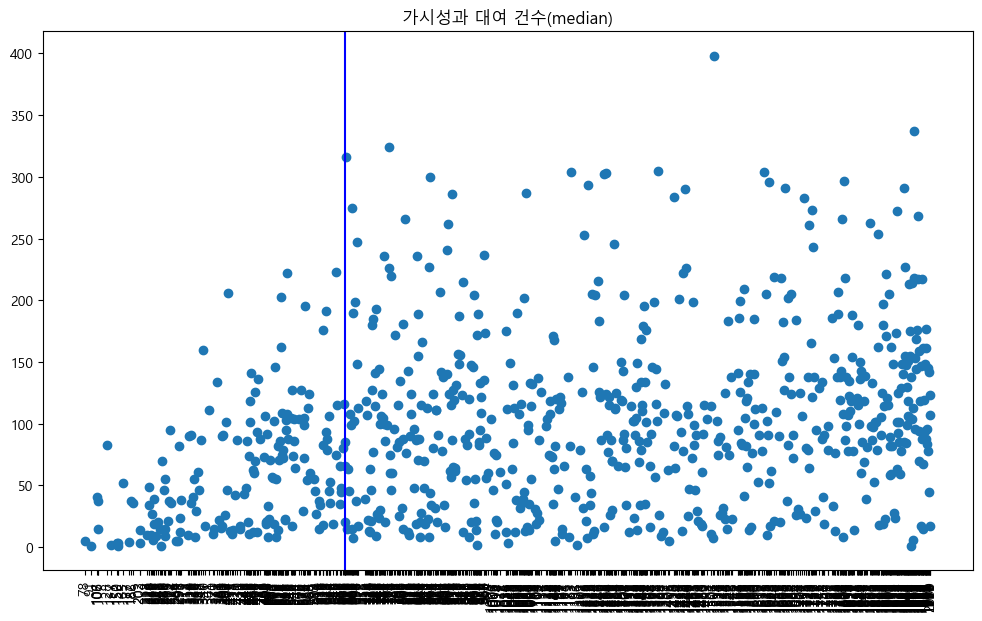

In [25]:

idx=data.groupby(by='hour_bef_visibility').median()['count'].index
value=data.groupby(by='hour_bef_visibility').median()['count'].values

plt.figure(figsize=(12,7))
plt.title('가시성과 대여 건수(median)')
plt.scatter(idx,value)
plt.axvline(x=670, color = 'b', label = 'axvline - full height')
plt.xticks(idx,rotation=90)
plt.show()

In [61]:

data.hour_bef_visibility.value_counts()


2000.0    339
990.0      12
1992.0      8
1994.0      7
1996.0      6
         ... 
574.0       1
951.0       1
1529.0      1
670.0       1
1262.0      1
Name: hour_bef_visibility, Length: 781, dtype: int64

In [59]:
test.hour_bef_visibility.value_counts()

2000.0    197
306.0       3
1969.0      3
1949.0      3
1274.0      3
         ... 
1794.0      1
1959.0      1
1954.0      1
1542.0      1
1277.0      1
Name: hour_bef_visibility, Length: 453, dtype: int64

##### 가시성별 확인
- 가시성 670 이후로 비교적 균등
    > 일정값 이상일 때 고정값으로 사용하기

---

In [80]:
data['visibility']=data.hour_bef_visibility.apply(lambda k : 670 if k>670 else k)
test['visibility']=test.hour_bef_visibility.apply(lambda k : 670 if k>670 else k)

data.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count,hour2,bin_temperature,bin_temperature2,temp,wind,visibility
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0,3,15이상19미만,15이상17미만,16.3,1.5,576.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0,3,19이상23미만,19이상21미만,20.1,1.4,670.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0,1,11이상15미만,13이상15미만,13.9,0.7,670.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0,2,7이상11미만,7이상9미만,8.1,2.7,670.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0,5,27이상31미만,29이상31미만,29.5,4.8,670.0


In [26]:
# 오존
data.hour_bef_ozone.value_counts()

0.036    34
0.040    33
0.044    32
0.042    32
0.033    31
         ..
0.098     1
0.093     1
0.095     1
0.106     1
0.112     1
Name: hour_bef_ozone, Length: 95, dtype: int64

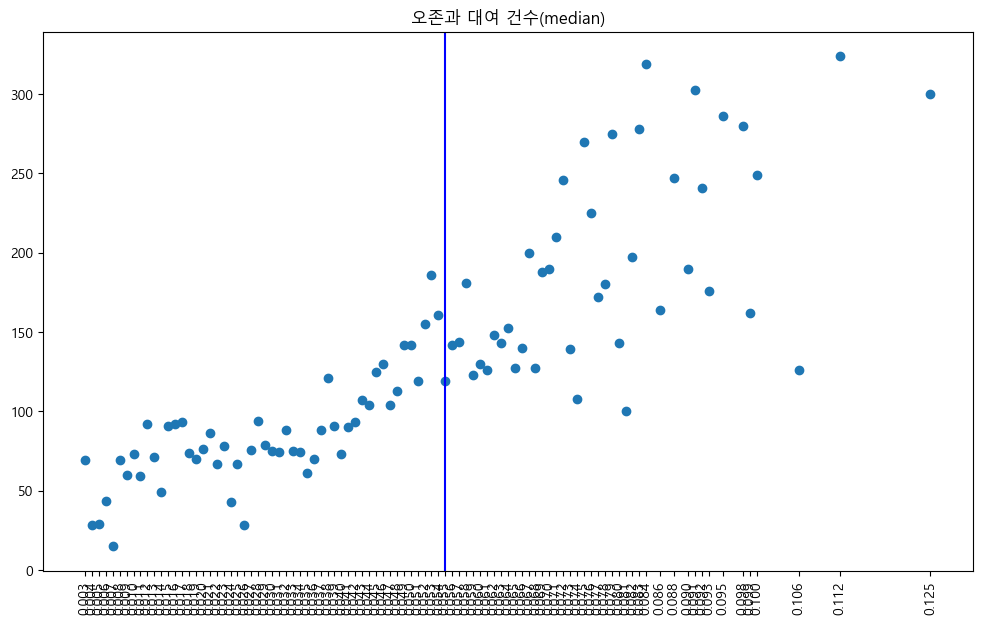

In [30]:

idx=data.groupby(by='hour_bef_ozone').median()['count'].index
value=data.groupby(by='hour_bef_ozone').median()['count'].values

plt.figure(figsize=(12,7))
plt.title('오존과 대여 건수(median)')
plt.scatter(idx,value)
plt.axvline(x=0.055, color = 'b', label = 'axvline - full height')
plt.xticks(idx,rotation=90)
plt.show()

##### 오존별 확인
- 양의 상관관계 ? 농도가 높을수록 대여건수 범위가 증가
    > 그냥 쓰기, 뺄까?
---

In [42]:
# 미세먼지 pm10
data.hour_bef_pm10.value_counts()



32.0     36
34.0     33
48.0     31
54.0     28
47.0     28
         ..
116.0     1
205.0     1
131.0     1
152.0     1
113.0     1
Name: hour_bef_pm10, Length: 148, dtype: int64

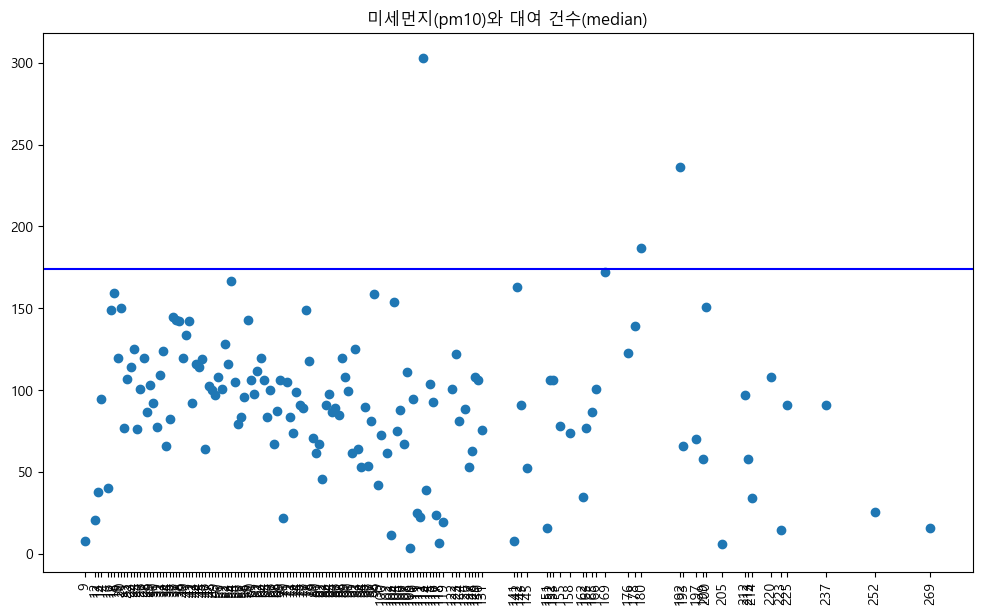

In [40]:

idx=data.groupby(by='hour_bef_pm10').median()['count'].index
value=data.groupby(by='hour_bef_pm10').median()['count'].values

plt.figure(figsize=(12,7))
plt.title('미세먼지(pm10)와 대여 건수(median)')
plt.scatter(idx,value)
plt.axhline(y=174, color = 'b', label = 'axvline - full height')
plt.xticks(idx,rotation=90)
plt.show()

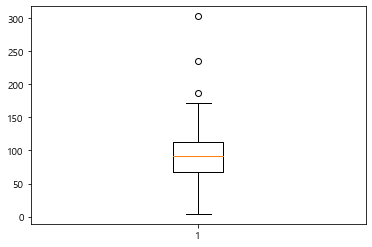

In [11]:
plt.boxplot(data.groupby(by='hour_bef_pm10').median()['count'].values)
plt.show()

##### 미세먼지 확인
- 특정값 이상일 경우 현저하게 감소
    > 이상치 제거 후 사용? 사용하지 말까?
    
---

In [47]:
# 미세먼지 pm2.5
data['hour_bef_pm2.5'].value_counts()



22.0    69
19.0    64
21.0    62
25.0    55
24.0    51
        ..
75.0     1
82.0     1
78.0     1
72.0     1
74.0     1
Name: hour_bef_pm2.5, Length: 79, dtype: int64

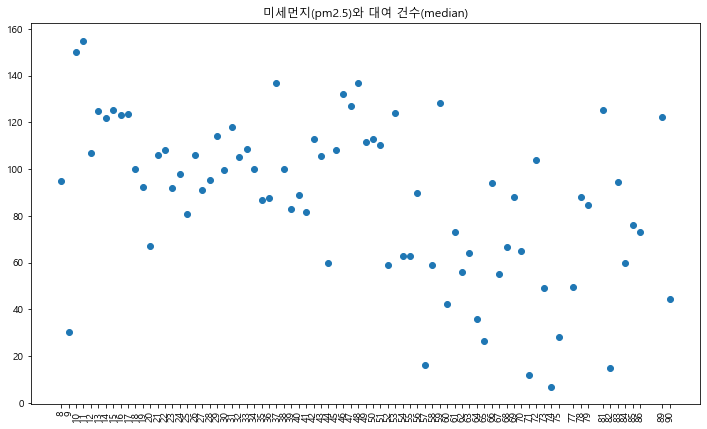

In [12]:

idx=data.groupby(by='hour_bef_pm2.5').median()['count'].index
value=data.groupby(by='hour_bef_pm2.5').median()['count'].values

plt.figure(figsize=(12,7))
plt.title('미세먼지(pm2.5)와 대여 건수(median)')
plt.scatter(idx,value)
# plt.axhline(y=174, color = 'b', label = 'axvline - full height')
plt.xticks(idx,rotation=90)
plt.show()

##### 2.5미세먼지 확인
- 반비례?
    > 특성 삭제?
---

---   
### 컬럼 정리하기

In [48]:
data.head()

#Index(['id', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
    #    'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
    #    'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count', 'hour2',
    #    'bin_temperature', 'bin_temperature2', 'temp', 'wind', 'visibility'],
    #   dtype='object')Index(['id', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
    #    'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
    #    'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count', 'hour2',
    #    'bin_temperature', 'bin_temperature2', 'temp', 'wind', 'visibility'],
    #   dtype='object')

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count,hour2,bin_temperature,bin_temperature2,temp,wind,visibility
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0,3,15이상19미만,15이상17미만,16.3,1.5,576.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0,3,19이상23미만,19이상21미만,20.1,1.4,670.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0,1,11이상15미만,13이상15미만,13.9,0.7,670.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0,2,7이상11미만,7이상9미만,8.1,2.7,670.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0,5,27이상31미만,29이상31미만,29.5,4.8,670.0


In [447]:
data2=data[['count', 'hour','hour2', 'hour_bef_precipitation','temp', 'wind','hour_bef_humidity', 'visibility','hour_bef_ozone','hour_bef_pm10', 'hour_bef_pm2.5']]
test2=test[['hour','hour2', 'hour_bef_precipitation','temp', 'wind','hour_bef_humidity', 'visibility','hour_bef_ozone','hour_bef_pm10', 'hour_bef_pm2.5']]
#오존 제거해보기

In [52]:
data2.corr()

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
count,1.000000,0.626047,0.750256,-0.163985,0.619404,0.490049,-0.471142,0.243108,0.477614,-0.114288,-0.134293
hour,0.626047,1.000000,0.686958,0.021646,0.407306,0.481438,-0.329612,0.145916,0.390188,-0.035907,-0.061229
hour2,0.750256,0.686958,1.000000,0.035385,0.452384,0.516073,-0.363699,0.139909,0.410452,-0.017082,-0.060617
hour_bef_precipitation,-0.163985,0.021646,0.035385,1.000000,-0.097056,0.010135,0.276481,-0.354476,-0.062461,-0.051266,0.004742
temp,0.619404,0.407306,0.452384,-0.097056,1.000000,0.393180,-0.496088,0.202939,0.541228,-0.003830,-0.078665
wind,0.490049,0.481438,0.516073,0.010135,0.393180,1.000000,-0.440859,0.127385,0.529603,-0.009905,-0.185084
hour_bef_humidity,-0.471142,-0.329612,-0.363699,0.276481,-0.496088,-0.440859,1.000000,-0.504979,-0.421047,-0.108106,0.167736
visibility,0.243108,0.145916,0.139909,-0.354476,0.202939,0.127385,-0.504979,1.000000,0.173128,-0.081637,-0.334587
hour_bef_ozone,0.477614,0.390188,0.410452,-0.062461,0.541228,0.529603,-0.421047,0.173128,1.000000,0.113015,0.017313
hour_bef_pm10,-0.114288,-0.035907,-0.017082,-0.051266,-0.003830,-0.009905,-0.108106,-0.081637,0.113015,1.000000,0.489558


In [82]:
test2

,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,7,2,0.0,20.7,1.3,62.0,670.0,0.041,44.0,27.0
1,17,4,0.0,30.0,4.6,33.0,670.0,0.061,49.0,36.0
2,13,3,1.0,19.0,2.1,95.0,193.0,0.020,36.0,28.0
3,6,1,0.0,22.5,2.5,60.0,670.0,0.027,52.0,38.0
4,22,3,1.0,14.6,3.4,93.0,218.0,0.041,18.0,15.0
...,...,...,...,...,...,...,...,...,...,...
710,1,1,0.0,24.6,2.4,60.0,670.0,NaN,NaN,NaN
711,1,1,0.0,18.1,1.0,55.0,670.0,NaN,NaN,NaN
712,9,2,0.0,23.3,2.3,66.0,670.0,0.020,17.0,15.0
713,16,3,0.0,27.0,1.6,46.0,670.0,0.032,40.0,26.0


In [414]:
#test 데이터셋 결측치 확인
test2.isnull().sum()

hour                       0
hour2                      0
hour_bef_precipitation     0
temp                       1
wind                       1
hour_bef_humidity          1
visibility                 1
hour_bef_ozone            35
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64

In [84]:
test2[test2.temp.isnull()]

,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
653,19,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# hour==19인 값들로 확인해보기

test2[test2.hour==19]

	# hour_bef_precipitation	temp	wind	hour_bef_humidity	visibility	hour_bef_ozone	hour_bef_pm10	hour_bef_pm2.5

,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
34,19,4,0.0,23.4,4.8,34.0,670.0,0.047,33.0,15.0
44,19,4,0.0,28.0,4.3,33.0,670.0,0.066,40.0,28.0
65,19,4,0.0,26.9,3.9,42.0,670.0,0.057,40.0,26.0
74,19,4,0.0,28.3,3.0,24.0,670.0,0.056,31.0,15.0
90,19,4,0.0,27.3,3.5,65.0,670.0,0.056,40.0,31.0
138,19,4,0.0,25.5,2.7,71.0,670.0,0.056,28.0,22.0
151,19,4,0.0,25.6,4.3,21.0,670.0,0.051,24.0,14.0
187,19,4,0.0,27.2,2.1,18.0,670.0,0.047,21.0,8.0
210,19,4,0.0,25.2,4.1,46.0,670.0,0.046,40.0,21.0
216,19,4,0.0,23.1,4.3,51.0,670.0,0.062,36.0,28.0


In [85]:
test2.loc[653,'hour_bef_precipitation']=0.0
test2.loc[653,'hour_bef_precipitation']

0.0

In [92]:
test2[test2.isnull()].columns

Index(['hour', 'hour2', 'hour_bef_precipitation', 'temp', 'wind',
       'hour_bef_humidity', 'visibility', 'hour_bef_ozone', 'hour_bef_pm10',
       'hour_bef_pm2.5'],
      dtype='object')

In [416]:
test3=test2.copy()

In [417]:
# 'hour_bef_humidity', 'visibility', 'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5' 중앙값으로 채우기

col_list=['temp','wind', 'hour_bef_humidity', 'visibility', 'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5']
for c in col_list:
    test3.loc[653,c]=test3[test3.hour==19][c].median()

In [418]:
test3.isnull().sum()

hour                       0
hour2                      0
hour_bef_precipitation     0
temp                       0
wind                       0
hour_bef_humidity          0
visibility                 0
hour_bef_ozone            34
hour_bef_pm10             36
hour_bef_pm2.5            35
dtype: int64

In [105]:
test3.hour_bef_ozone.value_counts(dropna=False)

NaN      34
0.031    23
0.046    22
0.032    21
0.041    20
         ..
0.138     1
0.125     1
0.094     1
0.119     1
0.074     1
Name: hour_bef_ozone, Length: 97, dtype: int64

In [419]:
value=test3[(test3.hour==15)&(test3.wind==3.7)].hour_bef_ozone.values[1]
test3.loc[212,'hour_bef_ozone']=value
test3[(test3.hour==15)&(test3.wind==3.7)]

,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
212,15,3,0.0,25.2,3.7,50.0,670.0,0.062,32.0,21.0
410,15,3,0.0,29.0,3.7,35.0,670.0,0.062,45.0,27.0


In [124]:
data2.corr()

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
count,1.000000,0.626047,0.750256,-0.163985,0.619404,0.490049,-0.471142,0.243108,0.477614,-0.114288,-0.134293
hour,0.626047,1.000000,0.686958,0.021646,0.407306,0.481438,-0.329612,0.145916,0.390188,-0.035907,-0.061229
hour2,0.750256,0.686958,1.000000,0.035385,0.452384,0.516073,-0.363699,0.139909,0.410452,-0.017082,-0.060617
hour_bef_precipitation,-0.163985,0.021646,0.035385,1.000000,-0.097056,0.010135,0.276481,-0.354476,-0.062461,-0.051266,0.004742
temp,0.619404,0.407306,0.452384,-0.097056,1.000000,0.393180,-0.496088,0.202939,0.541228,-0.003830,-0.078665
wind,0.490049,0.481438,0.516073,0.010135,0.393180,1.000000,-0.440859,0.127385,0.529603,-0.009905,-0.185084
hour_bef_humidity,-0.471142,-0.329612,-0.363699,0.276481,-0.496088,-0.440859,1.000000,-0.504979,-0.421047,-0.108106,0.167736
visibility,0.243108,0.145916,0.139909,-0.354476,0.202939,0.127385,-0.504979,1.000000,0.173128,-0.081637,-0.334587
hour_bef_ozone,0.477614,0.390188,0.410452,-0.062461,0.541228,0.529603,-0.421047,0.173128,1.000000,0.113015,0.017313
hour_bef_pm10,-0.114288,-0.035907,-0.017082,-0.051266,-0.003830,-0.009905,-0.108106,-0.081637,0.113015,1.000000,0.489558


In [420]:
test3.isnull().sum() #오존은 채우기

hour                       0
hour2                      0
hour_bef_precipitation     0
temp                       0
wind                       0
hour_bef_humidity          0
visibility                 0
hour_bef_ozone            33
hour_bef_pm10             36
hour_bef_pm2.5            35
dtype: int64

In [154]:
test3[test3.hour_bef_ozone.isnull()].hour.value_counts()

1     30
14     2
13     1
Name: hour, dtype: int64

In [421]:
oz=test3[(test3.hour==14) & (test3.visibility==670) ].hour_bef_ozone.median()

In [422]:
test3[test3.hour_bef_ozone.isnull()&(test3.hour==14) & (test3.visibility==670)].index

Int64Index([386, 658], dtype='int64')

In [423]:
test3.loc[386,'hour_bef_ozone'] =oz
test3.loc[658,'hour_bef_ozone'] =oz

In [424]:
test3.isnull().sum()

hour                       0
hour2                      0
hour_bef_precipitation     0
temp                       0
wind                       0
hour_bef_humidity          0
visibility                 0
hour_bef_ozone            31
hour_bef_pm10             36
hour_bef_pm2.5            35
dtype: int64

In [158]:
test3[test3.hour_bef_ozone.isnull()]

,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
32,1,1,0.0,22.8,2.4,52.0,670.0,NaN,NaN,NaN
40,1,1,1.0,21.5,0.5,90.0,347.0,NaN,NaN,NaN
47,1,1,0.0,22.8,1.2,57.0,670.0,NaN,NaN,NaN
86,1,1,0.0,20.0,2.0,65.0,670.0,NaN,NaN,NaN
92,1,1,0.0,20.0,1.7,31.0,670.0,NaN,NaN,NaN
102,1,1,1.0,15.1,2.2,98.0,224.0,NaN,NaN,NaN
114,1,1,0.0,18.7,1.4,41.0,670.0,NaN,NaN,NaN
126,1,1,0.0,19.2,1.4,80.0,670.0,NaN,NaN,NaN
129,1,1,0.0,23.6,0.9,83.0,466.0,NaN,NaN,NaN
209,1,1,0.0,18.6,2.4,37.0,670.0,NaN,NaN,NaN


In [425]:
test3['hour_bef_ozone'].fillna(test3[(test3.hour==13)&(test3.temp>=28)&(test3.temp<=28.8)].hour_bef_ozone.median(),inplace=True)

In [180]:
test3[test3.hour_bef_ozone.isnull()].temp.describe()

count    30.000000
mean     20.986667
std       2.333080
min      15.100000
25%      19.500000
50%      21.300000
75%      22.800000
max      24.700000
Name: temp, dtype: float64

In [426]:
test3.isnull().sum()

hour                       0
hour2                      0
hour_bef_precipitation     0
temp                       0
wind                       0
hour_bef_humidity          0
visibility                 0
hour_bef_ozone             0
hour_bef_pm10             36
hour_bef_pm2.5            35
dtype: int64

In [450]:
# 데이터셋 결측치 확인

data2.isnull().sum()

count                       0
hour                        0
hour2                       0
hour_bef_precipitation      2
temp                        2
wind                        9
hour_bef_humidity           2
visibility                  2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
dtype: int64

In [304]:
data2[data2.hour_bef_precipitation.isnull()] #hour_bef_precipitation 채우기

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
934,39.0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1035,1.0,18,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [451]:
data2.hour_bef_precipitation=data2.hour_bef_precipitation.fillna(0.0)
data2.hour_bef_precipitation.isnull().sum()

0

In [309]:
data2[data2.temp.isnull()] #temp 채우기

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
934,39.0,0,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1035,1.0,18,5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [313]:
data2[data2.hour==10].temp.mean(),data2[data2.hour==10].temp.median()

(16.24262295081968, 16.0)

In [452]:
data2.temp=data2.temp.fillna(data2[data2.hour==10].temp.median())
data2.isnull().sum()

count                       0
hour                        0
hour2                       0
hour_bef_precipitation      0
temp                        0
wind                        9
hour_bef_humidity           2
visibility                  2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
dtype: int64

In [315]:
data2[data2.wind.isnull()] #wind 채우기

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
18,208.0,13,3,0.0,22.6,NaN,41.0,670.0,0.046,64.0,39.0
244,38.0,1,1,0.0,14.1,NaN,55.0,670.0,NaN,NaN,NaN
260,17.0,3,1,0.0,14.0,NaN,50.0,670.0,0.049,35.0,22.0
376,58.0,0,2,0.0,14.3,NaN,49.0,670.0,0.044,37.0,20.0
780,181.0,20,3,0.0,16.5,NaN,31.0,670.0,0.058,39.0,18.0
934,39.0,0,2,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
1035,1.0,18,5,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
1138,116.0,12,3,0.0,21.4,NaN,44.0,670.0,0.044,61.0,37.0
1229,20.0,2,1,0.0,14.0,NaN,52.0,670.0,0.044,37.0,20.0


In [453]:
data2.loc[244,'wind']=data2.loc[244,'wind']=data2[(data2.hour==1)&(data2.temp==14.1)].wind.median()

In [327]:
data2[data2.wind.isnull()]

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
18,208.0,13,3,0.0,22.6,NaN,41.0,670.0,0.046,64.0,39.0
260,17.0,3,1,0.0,14.0,NaN,50.0,670.0,0.049,35.0,22.0
376,58.0,0,2,0.0,14.3,NaN,49.0,670.0,0.044,37.0,20.0
780,181.0,20,3,0.0,16.5,NaN,31.0,670.0,0.058,39.0,18.0
934,39.0,0,2,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
1035,1.0,18,5,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
1138,116.0,12,3,0.0,21.4,NaN,44.0,670.0,0.044,61.0,37.0
1229,20.0,2,1,0.0,14.0,NaN,52.0,670.0,0.044,37.0,20.0


(array([12.,  0., 10.,  0.,  2.,  0.,  3.,  2.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 8 artists>)

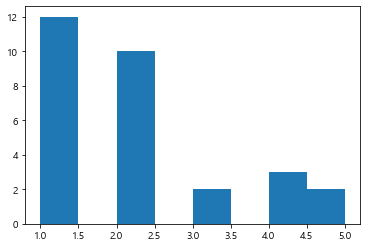

In [338]:
plt.hist(data2[data2.hour==3].wind.value_counts(),bins=8)

In [454]:
data2[(data2.hour==3)&(data2.temp>=16)&(data2.temp <=23)].wind.mean()
data2[(data2.hour==3)&(data2.temp>=16)&(data2.temp <=23)].wind.median()

data2.wind=data2.wind.fillna(data2[(data2.hour==3)&(data2.temp>=16)&(data2.temp <=23)].wind.median())
data2.isnull().sum()

count                       0
hour                        0
hour2                       0
hour_bef_precipitation      0
temp                        0
wind                        0
hour_bef_humidity           2
visibility                  2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
dtype: int64

In [351]:
data2[data2.hour_bef_humidity.isnull()] #hour_bef_humidity 채우기

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
934,39.0,0,2,0.0,16.0,1.3,NaN,NaN,NaN,NaN,NaN
1035,1.0,18,5,0.0,16.0,1.3,NaN,NaN,NaN,NaN,NaN


In [455]:
data2.hour_bef_humidity=data2.hour_bef_humidity.fillna(data2[data2.hour==0].hour_bef_humidity.median())
data2.isnull().sum()

count                       0
hour                        0
hour2                       0
hour_bef_precipitation      0
temp                        0
wind                        0
hour_bef_humidity           0
visibility                  2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
dtype: int64

In [357]:
data2[data2.visibility.isnull()] #visibility 채우기

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
934,39.0,0,2,0.0,16.0,1.3,59.0,NaN,NaN,NaN,NaN
1035,1.0,18,5,0.0,16.0,1.3,59.0,NaN,NaN,NaN,NaN


In [456]:
data2.visibility=data2.visibility.fillna(670)
data2.isnull().sum()

count                       0
hour                        0
hour2                       0
hour_bef_precipitation      0
temp                        0
wind                        0
hour_bef_humidity           0
visibility                  0
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
dtype: int64

In [369]:
data2[data2.hour_bef_ozone.isnull()]  #hour_bef_ozone 채우기

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
14,74.0,1,1,0.0,20.0,1.8,58.0,670.0,NaN,NaN,NaN
44,213.0,17,4,0.0,21.7,3.0,35.0,670.0,NaN,32.0,19.0
46,36.0,1,1,0.0,12.2,3.0,49.0,670.0,NaN,NaN,NaN
84,39.0,1,1,0.0,9.4,2.5,65.0,670.0,NaN,NaN,NaN
122,136.0,16,3,0.0,26.2,4.3,31.0,670.0,NaN,47.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...
1283,62.0,1,1,0.0,16.6,2.1,35.0,670.0,NaN,NaN,NaN
1322,40.0,1,1,0.0,15.1,1.3,35.0,670.0,NaN,NaN,NaN
1329,69.0,1,1,0.0,17.7,1.0,43.0,670.0,NaN,NaN,NaN
1361,43.0,1,1,0.0,12.6,2.4,48.0,670.0,NaN,NaN,NaN


In [402]:
data2[(data2.hour!=1) & (data2.hour_bef_ozone.isnull())]

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
44,213.0,17,4,0.0,21.7,3.0,35.0,670.0,NaN,32.0,19.0
122,136.0,16,3,0.0,26.2,4.3,31.0,670.0,NaN,47.0,23.0
140,66.0,10,2,0.0,18.2,2.4,60.0,527.0,NaN,NaN,NaN
422,320.0,18,5,0.0,20.3,4.1,24.0,670.0,NaN,57.0,27.0
451,236.0,17,4,0.0,20.1,4.5,25.0,670.0,NaN,58.0,29.0
532,121.0,12,3,0.0,22.3,2.8,51.0,575.0,NaN,NaN,NaN
537,127.0,7,2,0.0,18.7,2.0,69.0,670.0,NaN,NaN,NaN
595,95.0,11,2,0.0,20.3,2.6,56.0,576.0,NaN,NaN,NaN
631,131.0,15,3,0.0,26.3,3.6,30.0,670.0,NaN,50.0,22.0
645,53.0,6,1,0.0,18.7,1.0,72.0,634.0,NaN,NaN,NaN


In [404]:
data2[(data2.hour==16) & (data2.hour_bef_ozone.isnull())]

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
122,136.0,16,3,0.0,26.2,4.3,31.0,670.0,NaN,47.0,23.0
868,29.0,16,3,0.0,13.0,3.7,74.0,670.0,NaN,34.0,16.0
1211,182.0,16,3,0.0,23.0,2.9,26.0,670.0,NaN,22.0,8.0


In [457]:
data2[(data2.hour==16)&(data2.hour_bef_ozone.isnull())]=data2[(data2.hour==16)&(data2.hour_bef_ozone.isnull())].fillna(data2[(data2.hour==16)].hour_bef_ozone.median())

In [459]:
# hour==1 일때 hour_bef_ozone
hour_1=round(np.mean([data2[data2.hour==0].hour_bef_ozone.median(),data2[data2.hour==2].hour_bef_ozone.median()]),3)

data2[(data2.hour==1)&(data2.hour_bef_ozone.isnull())]=data2[(data2.hour==1)&(data2.hour_bef_ozone.isnull())].fillna(hour_1)

In [460]:
data2.isnull().sum()

count                      0
hour                       0
hour2                      0
hour_bef_precipitation     0
temp                       0
wind                       0
hour_bef_humidity          0
visibility                 0
hour_bef_ozone            12
hour_bef_pm10             29
hour_bef_pm2.5            56
dtype: int64

In [475]:
data2[(data2.hour==17)&(data2.temp>=20)&(data2.temp<=22)].hour_bef_ozone.median()

0.054

In [477]:
data2[(data2.hour==17)&(data2.hour_bef_ozone.isnull())]=data2[(data2.hour==17)&(data2.hour_bef_ozone.isnull())].fillna(data2[(data2.hour==17)&(data2.temp>=20)&(data2.temp<=22)].hour_bef_ozone.median())
data2.isnull().sum()

count                      0
hour                       0
hour2                      0
hour_bef_precipitation     0
temp                       0
wind                       0
hour_bef_humidity          0
visibility                 0
hour_bef_ozone            10
hour_bef_pm10             29
hour_bef_pm2.5            56
dtype: int64

In [483]:
data2[(data2.hour==18)&(data2.hour_bef_ozone.isnull())]

#422  - 1035일때 다른 값 넣어야 할듯

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
422,320.0,18,5,0.0,20.3,4.1,24.0,670.0,NaN,57.0,27.0
1035,1.0,18,5,0.0,16.0,1.3,59.0,670.0,NaN,NaN,NaN


In [484]:
#422
data2[(data2.hour==18)&(data2.temp>=20)&(data2.temp<=20.5)]

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
422,320.0,18,5,0.0,20.3,4.1,24.0,670.0,NaN,57.0,27.0
1436,242.0,18,5,0.0,20.3,4.7,25.0,670.0,0.053,43.0,20.0


In [485]:
data2.loc[422,'hour_bef_ozone']=data2.loc[1436,'hour_bef_ozone']
data2[(data2.hour==18)&(data2.temp>=20)&(data2.temp<=20.5)]

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
422,320.0,18,5,0.0,20.3,4.1,24.0,670.0,0.053,57.0,27.0
1436,242.0,18,5,0.0,20.3,4.7,25.0,670.0,0.053,43.0,20.0


In [488]:
data2[(data2.temp==16)&(data2.wind==1.3)]

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
934,39.0,0,2,0.0,16.0,1.3,59.0,670.0,NaN,NaN,NaN
1035,1.0,18,5,0.0,16.0,1.3,59.0,670.0,NaN,NaN,NaN
1071,37.0,6,1,0.0,16.0,1.3,56.0,670.0,0.005,65.0,50.0


In [489]:
data2.loc[934,'hour_bef_ozone']=data2.loc[1071,'hour_bef_ozone']

In [510]:
data2.loc[1035,'hour_bef_ozone']=data2[(data2.temp<=16.5) & (data2.temp>=15.5) & (data2['count']<=10)].hour_bef_ozone.median()

In [514]:
data2[data2.hour_bef_ozone.isnull()]

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
140,66.0,10,2,0.0,18.2,2.4,60.0,527.0,NaN,NaN,NaN
532,121.0,12,3,0.0,22.3,2.8,51.0,575.0,NaN,NaN,NaN
537,127.0,7,2,0.0,18.7,2.0,69.0,670.0,NaN,NaN,NaN
595,95.0,11,2,0.0,20.3,2.6,56.0,576.0,NaN,NaN,NaN
631,131.0,15,3,0.0,26.3,3.6,30.0,670.0,NaN,50.0,22.0
645,53.0,6,1,0.0,18.7,1.0,72.0,634.0,NaN,NaN,NaN
897,161.0,13,3,0.0,24.5,3.5,38.0,670.0,NaN,NaN,NaN


In [520]:
data2[(data2.hour==15)&(data2.temp>=26)&(data2.temp<=26.5)].hour_bef_ozone.median()

0.0595

In [521]:
data2.loc[631,'hour_bef_ozone']=data2[(data2.hour==15)&(data2.temp>=26)&(data2.temp<=26.5)].hour_bef_ozone.median()
data2[data2.hour_bef_ozone.isnull()]

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
140,66.0,10,2,0.0,18.2,2.4,60.0,527.0,NaN,NaN,NaN
532,121.0,12,3,0.0,22.3,2.8,51.0,575.0,NaN,NaN,NaN
537,127.0,7,2,0.0,18.7,2.0,69.0,670.0,NaN,NaN,NaN
595,95.0,11,2,0.0,20.3,2.6,56.0,576.0,NaN,NaN,NaN
645,53.0,6,1,0.0,18.7,1.0,72.0,634.0,NaN,NaN,NaN
897,161.0,13,3,0.0,24.5,3.5,38.0,670.0,NaN,NaN,NaN


In [531]:
data2.loc[537,'hour_bef_ozone']=data2[(data2.temp==18.7)&(data2.wind==2)].hour_bef_ozone.values[1]
data2[data2.hour_bef_ozone.isnull()]

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
140,66.0,10,2,0.0,18.2,2.4,60.0,527.0,NaN,NaN,NaN
532,121.0,12,3,0.0,22.3,2.8,51.0,575.0,NaN,NaN,NaN
595,95.0,11,2,0.0,20.3,2.6,56.0,576.0,NaN,NaN,NaN
645,53.0,6,1,0.0,18.7,1.0,72.0,634.0,NaN,NaN,NaN
897,161.0,13,3,0.0,24.5,3.5,38.0,670.0,NaN,NaN,NaN


In [540]:
data2.loc[897,'hour_bef_ozone'] = data2[(data2.visibility==670)&(data2.hour==13)&(data2.temp>=24)&(data2.temp<=25)].hour_bef_ozone.mean()
data2[data2.hour_bef_ozone.isnull()]

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
140,66.0,10,2,0.0,18.2,2.4,60.0,527.0,NaN,NaN,NaN
532,121.0,12,3,0.0,22.3,2.8,51.0,575.0,NaN,NaN,NaN
595,95.0,11,2,0.0,20.3,2.6,56.0,576.0,NaN,NaN,NaN
645,53.0,6,1,0.0,18.7,1.0,72.0,634.0,NaN,NaN,NaN


In [545]:
data2[(data2.temp<=22.5)&(data2.temp>=20.1)&(data2.wind<=3)&(data2.wind>=2.4)].hour_bef_ozone.median()

0.0535

In [547]:
data2[(data2.visibility<=580)&(data2.visibility>=570)&(data2['count']>100)]

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
327,195.0,17,4,0.0,19.5,2.6,54.0,579.0,0.059,66.0,51.0
532,121.0,12,3,0.0,22.3,2.8,51.0,575.0,NaN,NaN,NaN
762,171.0,18,5,0.0,16.9,2.4,64.0,570.0,0.050,73.0,57.0
1127,159.0,22,3,0.0,17.7,2.5,66.0,577.0,0.070,92.0,51.0


In [558]:
data2.loc[532,'hour_bef_ozone']= data2[(data2.visibility<=580)&(data2.visibility>=570)&(data2['count']>100)].hour_bef_ozone.median()
data2[data2.hour_bef_ozone.isnull()]

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
140,66.0,10,2,0.0,18.2,2.4,60.0,527.0,NaN,NaN,NaN
595,95.0,11,2,0.0,20.3,2.6,56.0,576.0,NaN,NaN,NaN
645,53.0,6,1,0.0,18.7,1.0,72.0,634.0,NaN,NaN,NaN


In [559]:
data2[((data2.hour==10)|(data2.hour==11))    &((data2.temp>=18)&(data2.temp<=20.5)) &(data2['count']<=100) &(data2.hour_bef_humidity>=50)&(data2.hour_bef_humidity<=80)]

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
140,66.0,10,2,0.0,18.2,2.4,60.0,527.0,NaN,NaN,NaN
183,66.0,11,2,0.0,19.6,2.9,50.0,602.0,0.061,193.0,54.0
491,78.0,11,2,0.0,18.4,0.9,57.0,670.0,0.027,39.0,21.0
525,89.0,10,2,0.0,19.1,2.4,69.0,670.0,0.039,56.0,33.0
594,85.0,11,2,0.0,20.3,2.4,69.0,670.0,0.054,58.0,38.0
595,95.0,11,2,0.0,20.3,2.6,56.0,576.0,NaN,NaN,NaN
648,74.0,10,2,0.0,19.8,2.8,71.0,670.0,0.048,60.0,36.0
1292,96.0,10,2,0.0,18.2,1.0,52.0,670.0,0.010,51.0,28.0
1319,88.0,11,2,0.0,18.3,0.8,58.0,670.0,0.018,56.0,24.0


In [563]:
oz2=data2[((data2.hour==10)|(data2.hour==11))&((data2.temp>=18)&(data2.temp<=20.5)) &(data2['count']<=100) &(data2.hour_bef_humidity>=50)&(data2.hour_bef_humidity<=80)].hour_bef_ozone.median()

data2.loc[140,'hour_bef_ozone']=oz2
data2.loc[595,'hour_bef_ozone']=oz2
data2[data2.hour_bef_ozone.isnull()]

,count,hour,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
645,53.0,6,1,0.0,18.7,1.0,72.0,634.0,NaN,NaN,NaN


In [570]:
data2.loc[645,'hour_bef_ozone']=data2[(data2.wind==1)&(data['count']<70)&(data.hour==6)].hour_bef_ozone.mean()
data2.isnull().sum()

count                      0
hour                       0
hour2                      0
hour_bef_precipitation     0
temp                       0
wind                       0
hour_bef_humidity          0
visibility                 0
hour_bef_ozone             0
hour_bef_pm10             29
hour_bef_pm2.5            56
dtype: int64

In [574]:
data2.hour_bef_pm10=data2.hour_bef_pm10.fillna(data2.hour_bef_pm10.median())
data2['hour_bef_pm2.5']=data2['hour_bef_pm2.5'].fillna(data2['hour_bef_pm2.5'].median())

In [575]:
data2.isnull().sum()

count                     0
hour                      0
hour2                     0
hour_bef_precipitation    0
temp                      0
wind                      0
hour_bef_humidity         0
visibility                0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
dtype: int64

In [577]:
test3.hour_bef_pm10=test3.hour_bef_pm10.fillna(test3.hour_bef_pm10.median())
test3['hour_bef_pm2.5']=test3['hour_bef_pm2.5'].fillna(test3['hour_bef_pm2.5'].median())
test3.isnull().sum()

hour                      0
hour2                     0
hour_bef_precipitation    0
temp                      0
wind                      0
hour_bef_humidity         0
visibility                0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
dtype: int64

---   
### 정규화
    - 1. robust
    - 2. powertrans

In [579]:
data2.columns

Index(['count', 'hour', 'hour2', 'hour_bef_precipitation', 'temp', 'wind',
       'hour_bef_humidity', 'visibility', 'hour_bef_ozone', 'hour_bef_pm10',
       'hour_bef_pm2.5'],
      dtype='object')

In [581]:
data4=data2[['count', 'hour2', 'hour_bef_precipitation', 'temp', 'wind', 'hour_bef_humidity', 'visibility', 'hour_bef_ozone']]
test4=test3[['hour2', 'hour_bef_precipitation', 'temp', 'wind', 'hour_bef_humidity', 'visibility', 'hour_bef_ozone']]
data4.head()

,count,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone
0,49.0,3,1.0,16.3,1.5,89.0,576.0,0.027
1,159.0,3,0.0,20.1,1.4,48.0,670.0,0.042
2,26.0,1,0.0,13.9,0.7,79.0,670.0,0.033
3,57.0,2,0.0,8.1,2.7,54.0,670.0,0.040
4,431.0,5,0.0,29.5,4.8,7.0,670.0,0.057


In [582]:
test4.head()

,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone
0,2,0.0,20.7,1.3,62.0,670.0,0.041
1,4,0.0,30.0,4.6,33.0,670.0,0.061
2,3,1.0,19.0,2.1,95.0,193.0,0.020
3,1,0.0,22.5,2.5,60.0,670.0,0.027
4,3,1.0,14.6,3.4,93.0,218.0,0.041


In [583]:
#데이터셋 나누기
train=data4.iloc[:,1:]
label=data4['count']
test=test4

In [584]:
train.head(2)

#정규화 할 컬럼 : 	temp	wind	hour_bef_humidity	visibility	hour_bef_ozone  2:

,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone
0,3,1.0,16.3,1.5,89.0,576.0,0.027
1,3,0.0,20.1,1.4,48.0,670.0,0.042


In [585]:
train_ro=train.copy()
train_tr=train.copy()

test_ro=test.copy()
test_tr=test.copy()

In [586]:
robust=RobustScaler()
power=PowerTransformer()

train_ro[['temp', 'wind', 'hour_bef_humidity','visibility', 'hour_bef_ozone']]=robust.fit_transform(train_ro[['temp', 'wind', 'hour_bef_humidity','visibility', 'hour_bef_ozone']])
train_tr[['temp', 'wind', 'hour_bef_humidity','visibility', 'hour_bef_ozone']]=power.fit_transform(train_tr[['temp', 'wind', 'hour_bef_humidity','visibility', 'hour_bef_ozone']])

test_ro[['temp', 'wind', 'hour_bef_humidity','visibility', 'hour_bef_ozone']]=robust.fit_transform(test_ro[['temp', 'wind', 'hour_bef_humidity','visibility', 'hour_bef_ozone']])
test_tr[['temp', 'wind', 'hour_bef_humidity','visibility', 'hour_bef_ozone']]=power.fit_transform(test_tr[['temp', 'wind', 'hour_bef_humidity','visibility', 'hour_bef_ozone']])


In [587]:
train_ro.head(2)

,hour2,hour_bef_precipitation,temp,wind,hour_bef_humidity,visibility,hour_bef_ozone
0,3,1.0,-0.041379,-0.40,1.169231,-94.0,-0.44
1,3,0.0,0.482759,-0.45,-0.092308,0.0,0.16


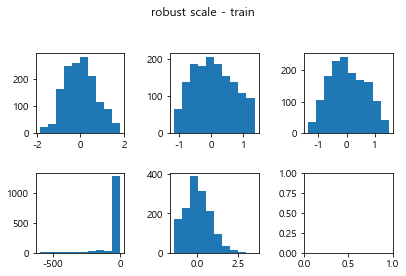

In [590]:
sub_plot=plt.subplots(2,3)
fig = sub_plot[0]
graph = sub_plot[1]


graph[0][0].hist(train_ro.temp)
graph[0][1].hist(train_ro.wind)
graph[0][2].hist(train_ro.hour_bef_humidity)
graph[1][0].hist(train_ro.visibility)
graph[1][1].hist(train_ro.hour_bef_ozone)

fig.suptitle('robust scale - train')
fig.tight_layout(pad=2)
plt.show()

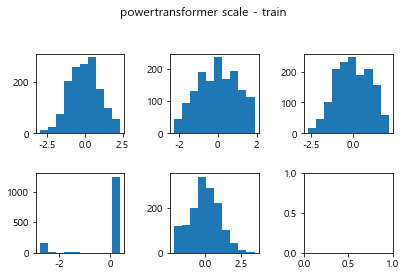

In [591]:
sub_plot=plt.subplots(2,3)
fig = sub_plot[0]
graph = sub_plot[1]


graph[0][0].hist(train_tr.temp)
graph[0][1].hist(train_tr.wind)
graph[0][2].hist(train_tr.hour_bef_humidity)
graph[1][0].hist(train_tr.visibility)
graph[1][1].hist(train_tr.hour_bef_ozone)

fig.suptitle('powertransformer scale - train')
fig.tight_layout(pad=2)
plt.show()

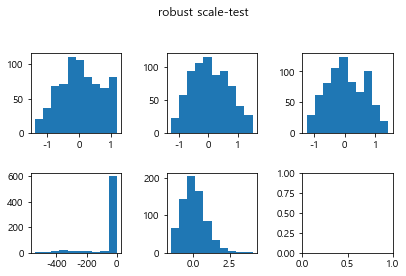

In [592]:

sub_plot=plt.subplots(2,3)
fig = sub_plot[0]
graph = sub_plot[1]


graph[0][0].hist(test_ro.temp)
graph[0][1].hist(test_ro.wind)
graph[0][2].hist(test_ro.hour_bef_humidity)
graph[1][0].hist(test_ro.visibility)
graph[1][1].hist(test_ro.hour_bef_ozone)

fig.suptitle('robust scale-test')
fig.tight_layout(pad=2)
plt.show()

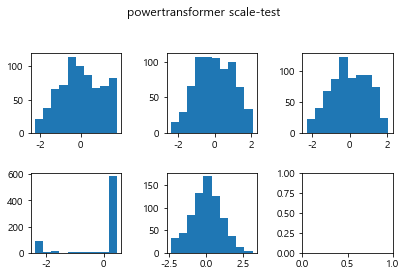

In [593]:

sub_plot=plt.subplots(2,3)
fig = sub_plot[0]
graph = sub_plot[1]


graph[0][0].hist(test_tr.temp)
graph[0][1].hist(test_tr.wind)
graph[0][2].hist(test_tr.hour_bef_humidity)
graph[1][0].hist(test_tr.visibility)
graph[1][1].hist(test_tr.hour_bef_ozone)

fig.suptitle('powertransformer scale-test')
fig.tight_layout(pad=2)
plt.show()

In [ ]:
#우선 파워트랜스폼 사용해보기
train_tr , test_tr

In [594]:
train_ro.to_csv('./train_ro.csv',encoding='utf-8',index=False)
train_tr.to_csv('./train_tr.csv',encoding='utf-8',index=False)
test_ro.to_csv('./test_ro.csv',encoding='utf-8',index=False)
test_tr.to_csv('./test_tr.csv',encoding='utf-8',index=False)
label.to_csv('./label.csv',encoding='utf-8',index=False)

---
## 모델찾기

In [620]:
all_model = all_estimators(type_filter = 'regressor')
x_train,x_test,y_train,y_test=train_test_split(train_tr,label,test_size=0.3,random_state=156)
m_dict=dict()
for (name, algorithm) in all_model:
    try:
        model = algorithm()
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        print(name, 'MSE', mean_squared_error(y_test, y_pred))
        m_dict[name]=mean_squared_error(y_test, y_pred)

        # print(name, 'R^2', r2_score(y_test, y_pred))
    except:
        print(f'{name} - 모델 없음')
        continue

ARDRegression MSE 2068.411712165547
AdaBoostRegressor MSE 2719.2396373454903
BaggingRegressor MSE 2103.73401826484
BayesianRidge MSE 2068.8877188288902
CCA MSE 3467.5462100552622
DecisionTreeRegressor MSE 3599.5
DummyRegressor MSE 6795.088428278009
ElasticNet MSE 2451.503255358119
ElasticNetCV MSE 2130.1941051903245
ExtraTreeRegressor MSE 3759.9109589041095
ExtraTreesRegressor MSE 1949.6001497716895
GammaRegressor MSE 2614.8499143604013
GaussianProcessRegressor MSE 294236.88428105216
GeneralizedLinearRegressor MSE 2750.3479252739025
GradientBoostingRegressor MSE 2075.8526819908766
HistGradientBoostingRegressor MSE 2143.906679411625
HuberRegressor MSE 2113.575037685502
IsotonicRegression - 모델 없음
KNeighborsRegressor MSE 2281.760547945206
KernelRidge MSE 2057.6684542968787
Lars MSE 2072.450727658224
LarsCV MSE 2072.450727658224
Lasso MSE 2076.874843104567
LassoCV MSE 2070.145566062592
LassoLars MSE 3650.1507460902053
LassoLarsCV MSE 2072.450727658224
LassoLarsIC MSE 2072.450727658224
Line

In [623]:
m_dict2=sorted(m_dict.items(), key=lambda x: x[1])

m_list=[]
for i in m_dict2[:10]:
    m_list.append(i[0])

m_dict2[:10] 

[('ExtraTreesRegressor', 1949.6001497716895),
 ('RandomForestRegressor', 1983.7942527397263),
 ('KernelRidge', 2057.6684542968787),
 ('ARDRegression', 2068.411712165547),
 ('BayesianRidge', 2068.8877188288902),
 ('LassoCV', 2070.145566062592),
 ('RidgeCV', 2070.6105640705428),
 ('Ridge', 2070.610564070632),
 ('LinearRegression', 2072.4507276582235),
 ('TransformedTargetRegressor', 2072.4507276582235)]

In [629]:
# robust
all_model = all_estimators(type_filter = 'regressor')
x_train,x_test,y_train,y_test=train_test_split(train_ro,label,test_size=0.3,random_state=156)
m_dict=dict()
for (name, algorithm) in all_model:
    try:
        model = algorithm()
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        print(name, 'MSE', mean_squared_error(y_test, y_pred))
        m_dict[name]=mean_squared_error(y_test, y_pred)

        # print(name, 'R^2', r2_score(y_test, y_pred))
    except:
        print(f'{name} - 모델 없음')
        continue

ARDRegression MSE 2075.090674755823
AdaBoostRegressor MSE 2736.285524587692
BaggingRegressor MSE 2006.1171232876713
BayesianRidge MSE 2072.9666133489345
CCA MSE 3542.039596732926
DecisionTreeRegressor MSE 3437.6666666666665
DummyRegressor MSE 6795.088428278009
ElasticNet MSE 2436.950145647887
ElasticNetCV MSE 3565.5658155849924
ExtraTreeRegressor MSE 3617.0502283105025
ExtraTreesRegressor MSE 1963.698665296804
GammaRegressor MSE 6795.088428278009
GaussianProcessRegressor MSE 3192178.4913468077
GeneralizedLinearRegressor MSE 2797.7088848993185
GradientBoostingRegressor MSE 2062.9184888872737
HistGradientBoostingRegressor MSE 2158.802043434679
HuberRegressor MSE 2116.1443917687325
IsotonicRegression - 모델 없음
KNeighborsRegressor MSE 2222.970502283105
KernelRidge MSE 2063.1772576968447
Lars MSE 2076.639090756854
LarsCV MSE 2076.639090756854
Lasso MSE 2069.9967907674013
LassoCV MSE 2128.0407178609225
LassoLars MSE 3626.6969810523524
LassoLarsCV MSE 2076.639090756854
LassoLarsIC MSE 2076.6390

In [630]:
m_dict2=sorted(m_dict.items(), key=lambda x: x[1])[:10]

m_list2=[]
for i in m_dict2[:10]:
    m_list2.append(i[0])

m_dict2[:10]


[('ExtraTreesRegressor', 1963.698665296804),
 ('BaggingRegressor', 2006.1171232876713),
 ('RandomForestRegressor', 2010.592620091324),
 ('GradientBoostingRegressor', 2062.9184888872737),
 ('KernelRidge', 2063.1772576968447),
 ('Lasso', 2069.9967907674013),
 ('BayesianRidge', 2072.9666133489345),
 ('Ridge', 2074.6453318410886),
 ('RidgeCV', 2074.645331889235),
 ('ARDRegression', 2075.090674755823)]

In [631]:
m_list, m_list2

(['ExtraTreesRegressor',
  'RandomForestRegressor',
  'KernelRidge',
  'ARDRegression',
  'BayesianRidge',
  'LassoCV',
  'RidgeCV',
  'Ridge',
  'LinearRegression',
  'TransformedTargetRegressor'],
 ['ExtraTreesRegressor',
  'BaggingRegressor',
  'RandomForestRegressor',
  'GradientBoostingRegressor',
  'KernelRidge',
  'Lasso',
  'BayesianRidge',
  'Ridge',
  'RidgeCV',
  'ARDRegression'])

In [ ]:
# from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor,BaggingRegressor
# from sklearn.kernel_ridge import KernelRidge

---
#### 1. 엑스트라 트리

In [637]:
extra_trees = ExtraTreesRegressor(n_estimators=100, random_state=42)
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)


mse_scores = cross_val_score(extra_trees, train_tr,label, cv=kfold, scoring='neg_mean_squared_error')
mse = mse_scores.mean()

print("Mean Squared Error:", mse)




mse_scores2 = cross_val_score(extra_trees, train_ro,label, cv=kfold, scoring='neg_mean_squared_error')
mse2 = mse_scores2.mean()

print("Mean Squared Error:", mse2)

Mean Squared Error: -1962.952390155881
Mean Squared Error: -1958.9015445418045


---
#### 2. 랜덤포레스트

In [638]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)


mse_scores = cross_val_score(rf, train_tr,label, cv=kfold, scoring='neg_mean_squared_error')
mse = mse_scores.mean()

print("Mean Squared Error:", mse)




mse_scores2 = cross_val_score(rf, train_ro,label, cv=kfold, scoring='neg_mean_squared_error')
mse2 = mse_scores2.mean()

print("Mean Squared Error:", mse2)

Mean Squared Error: -1979.0873782012284
Mean Squared Error: -1979.6903131950876


---
#### 3. 커널릿지

In [639]:
kernel_ridge = KernelRidge()

n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)


mse_scores = cross_val_score(kernel_ridge, train_tr,label, cv=kfold, scoring='neg_mean_squared_error')
mse = mse_scores.mean()

print("Mean Squared Error:", mse)




mse_scores2 = cross_val_score(kernel_ridge, train_ro,label, cv=kfold, scoring='neg_mean_squared_error')
mse2 = mse_scores2.mean()

print("Mean Squared Error:", mse2)

Mean Squared Error: -2148.288311309686
Mean Squared Error: -2138.9618865859366


In [ ]:
# 엑스트라 트리모델 사용하기

---
### 최적화

In [650]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2','auto'])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    model = ExtraTreesRegressor(n_estimators=n_estimators,
                                max_depth=max_depth,
                                min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf,
                                max_features=max_features,
                                bootstrap=bootstrap)

    score = cross_val_score(model, train_ro, label, cv=7, scoring='neg_mean_squared_error')
    rmse_score = -1.0 * score.mean()

    return rmse_score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_model = ExtraTreesRegressor(**best_params)

best_score = cross_val_score(best_model, train_ro, label, cv=7, scoring='neg_mean_squared_error')
best_rmse_score = -1.0 * best_score.mean()
print("Best RMSE score:", best_rmse_score)


[I 2023-03-11 22:23:55,725] A new study created in memory with name: no-name-6e74c6c2-a3ff-464d-ab11-bac92205afd5
[I 2023-03-11 22:23:59,216] Trial 0 finished with value: 2096.840789314287 and parameters: {'n_estimators': 418, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'auto', 'bootstrap': True}. Best is trial 0 with value: 2096.840789314287.
[I 2023-03-11 22:24:02,908] Trial 1 finished with value: 2393.0928771131903 and parameters: {'n_estimators': 458, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 2096.840789314287.
[I 2023-03-11 22:24:04,399] Trial 2 finished with value: 2004.8688815191322 and parameters: {'n_estimators': 166, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'auto', 'bootstrap': True}. Best is trial 2 with value: 2004.8688815191322.
[I 2023-03-11 22:24:06,911] Trial 3 finished with value: 2000.19656628319 and par

Best RMSE score: 1881.1904982667977


In [654]:
best_params

{'n_estimators': 282,
 'max_depth': 10,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'bootstrap': True}

In [665]:
best_model2

ExtraTreesRegressor(bootstrap=True, max_depth=12, min_samples_split=9,
                    n_estimators=172)

In [680]:
model = ExtraTreesRegressor(bootstrap=True, max_depth=12, min_samples_split=9, n_estimators=172)

mse_scores = []
for train_index, test_index in kfold.split(train_ro):
    X_train, X_test = train_ro.iloc[train_index], train_ro.iloc[test_index]
    y_train, y_test = label.iloc[train_index], label.iloc[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(test_ro)


In [681]:
y_pred

array([ 74.90193762, 244.90639853,  37.01037707,  27.17647418,
        21.48450181,  90.26674599, 143.58294001, 280.89361341,
        18.87310569,  71.28975818, 173.66068066, 204.77613537,
       145.00550524,  27.0069434 ,  85.67002627, 219.64645062,
        31.01127932,  43.13623235, 310.04862378, 130.69420088,
       188.31950456,  62.20369874,  24.08181745, 163.4568529 ,
       141.83803603, 102.42853697,  21.40463585,  87.01529373,
        80.51707821, 192.18667173,  71.53018858,  28.00026919,
        32.48329287, 161.6057448 , 173.80074013,  24.48615347,
       161.46169629,  92.37111091, 214.24732763,  55.10320265,
        14.36205589, 105.3666212 , 132.46741594,  46.8016203 ,
       229.66006422, 128.00889071,  54.7698455 ,  28.70562062,
        18.88352874,  80.99420304, 221.30868796, 103.70269051,
       105.62994494,  19.86735525, 180.2954826 , 121.27214386,
        23.99025755, 134.71811258,  27.09375215,  19.77326369,
        75.33699005,  72.81690338, 223.70741091, 199.87

In [682]:
ypred2=y_pred.astype('int')

In [683]:
ypred2

array([ 74, 244,  37,  27,  21,  90, 143, 280,  18,  71, 173, 204, 145,
        27,  85, 219,  31,  43, 310, 130, 188,  62,  24, 163, 141, 102,
        21,  87,  80, 192,  71,  28,  32, 161, 173,  24, 161,  92, 214,
        55,  14, 105, 132,  46, 229, 128,  54,  28,  18,  80, 221, 103,
       105,  19, 180, 121,  23, 134,  27,  19,  75,  72, 223, 199,  78,
       218,  18, 208, 118,  28, 107,  21, 133,  27, 212, 187,  16, 157,
       194,  24, 150, 159,  70,  92,  53, 282,  21, 192,  78, 161, 195,
       130,  20, 112,  24,  72,  75,  16, 128,  76,  21, 158,  11,  85,
        44,  35,  99,  23, 198,  63, 176, 193,  79,  98,  19, 140, 104,
        26, 186,  18, 103,  50,  42,  64,  37,  72,  22,  21, 177,  30,
       154, 190,  17, 173, 164, 169,  29, 166, 179, 289, 135,  22,  23,
        56,  81, 107,  95,  77, 186, 208, 165, 200, 256, 233, 125,   9,
        72,  13,  95, 164, 186,  25, 144, 217, 156,  33, 120, 135, 175,
        33,  90, 154,  80, 161, 101,  63, 149, 136, 183, 137, 13

In [685]:
sub['count']=ypred2

In [686]:
sub.to_csv('./result2_rob_extratr.csv',encoding='utf-8',index=False)

---

In [ ]:
# data2,test2= null값 입력한 데이터
del data2['id']
del test2['id']

In [ ]:
data2.shape

(1459, 10)

In [ ]:
test2.shape

(715, 9)

In [ ]:
condata=pd.concat([data2, test2], axis = 0)

In [ ]:
condata

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,20.0,16.3,1.0,1.5,89.0,576.0,0.02700,76.00,33.00,49.0
1,13.0,20.1,0.0,1.4,48.0,916.0,0.04200,73.00,40.00,159.0
2,6.0,13.9,0.0,0.7,79.0,1382.0,0.03300,32.00,19.00,26.0
3,23.0,8.1,0.0,2.7,54.0,946.0,0.04000,75.00,64.00,57.0
4,18.0,29.5,0.0,4.8,7.0,2000.0,0.05700,27.00,11.00,431.0
...,...,...,...,...,...,...,...,...,...,...
710,1.0,24.6,0.0,2.4,60.0,1745.0,0.03299,32.88,23.78,NaN
711,1.0,18.1,0.0,1.0,55.0,2000.0,0.02866,32.64,19.03,NaN
712,9.0,23.3,0.0,2.3,66.0,1789.0,0.02000,17.00,15.00,NaN
713,16.0,27.0,0.0,1.6,46.0,1956.0,0.03200,40.00,26.00,NaN


In [ ]:

imputer = MissForest()
imputed_data = imputer.fit_transform(condata)
condata2=pd.DataFrame(imputed_data,columns=condata.columns)


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [ ]:
sub['count']=condata2.iloc[1459:,-1].values

In [ ]:
sub.to_csv('./result_miss.csv',encoding='utf-8',index=False)